### Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Dataset

In [2]:
raw_data = yfinance.download(
                    tickers=["ICICIBANK.NS", "^NSEI", "^BSESN", "HDFCBANK.NS"],
                    start="2014-12-31",
                    group_by="ticker",
                    auto_adjust=True,
                    interval="1d",
                    treads=True
                    )

[*********************100%***********************]  4 of 4 completed


### Data Preprocessing

In [3]:
df = raw_data.copy()
df["icici"] = df["ICICIBANK.NS"].Close
df["bse"] = df["^BSESN"].Close
df["nse"] = df["^NSEI"].Close
df["hdfc"] = df["HDFCBANK.NS"].Close

del  df["^NSEI"], df["^BSESN"], df["ICICIBANK.NS"], df["HDFCBANK.NS"]
df = df.asfreq("b")
df = df.fillna(method="bfill")
df["icici_ret"] = df.icici.pct_change(1).mul(100)
df["bse_ret"] = df.bse.pct_change(1).mul(100)
df["nse_ret"] = df.nse.pct_change(1).mul(100)
df["hdfc_ret"]=df.hdfc.pct_change(1).mul(100)
df.head()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2014-12-31,300.588135,27499.419922,8282.700195,458.484467,NaN,NaN,NaN,NaN
2015-01-01,299.907104,27887.900391,8395.450195,458.701355,-0.226566,1.412686,1.361271,0.047306
2015-01-02,308.419952,27887.900391,8395.450195,465.085205,2.838495,0.000000,0.000000,1.391723
2015-01-05,309.058350,27842.320312,8378.400391,461.158539,0.206990,-0.163440,-0.203084,-0.844290
2015-01-06,295.948639,26987.460938,8127.350098,453.979614,-4.241824,-3.070360,-2.996399,-1.556715


### Train-Test Split

In [4]:
train_idx = int(len(df)*0.7)
val_idx = train_idx+int(len(df)*0.15)

df_train, df_val, df_test = df.iloc[:train_idx], df.iloc[train_idx:val_idx], df.iloc[val_idx:]

In [5]:
df_train.tail()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2019-04-17,402.434021,39140.281250,11752.799805,1137.210083,-0.638823,-0.344640,-0.291424,-0.494578
2019-04-18,402.434021,39140.281250,11752.799805,1137.210083,0.000000,0.000000,0.000000,0.000000
2019-04-19,392.582153,38645.179688,11594.450195,1124.839844,-2.448070,-1.264941,-1.347335,-1.087771
2019-04-22,392.582153,38645.179688,11594.450195,1124.839844,0.000000,0.000000,0.000000,0.000000
2019-04-23,394.572418,38564.878906,11575.950195,1113.237915,0.506968,-0.207790,-0.159559,-1.031429


In [6]:
df_val.head()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2019-04-24,399.150085,39054.679688,11726.150391,1130.318481,1.160159,1.270070,1.297519,1.534314
2019-04-25,393.477783,38730.859375,11641.799805,1122.236694,-1.421095,-0.829146,-0.719337,-0.715001
2019-04-26,405.220428,39067.328125,11754.650391,1130.913452,2.984322,0.868736,0.969357,0.773166
2019-04-29,405.518982,39031.550781,11748.150391,1149.010376,0.073677,-0.091579,-0.055297,1.600204
2019-04-30,405.518982,39031.550781,11748.150391,1149.010376,0.000000,0.000000,0.000000,0.000000


In [38]:
df_val.tail()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2020-03-19,338.549988,28288.230469,8263.450195,895.549988,-4.647233,-2.013471,-2.424778,2.126806
2020-03-20,345.700012,29915.960938,8745.450195,882.849976,2.111955,5.754091,5.832915,-1.418124
2020-03-23,284.000000,25981.240234,7610.250000,771.549988,-17.847848,-13.152580,-12.980466,-12.606897
2020-03-24,296.500000,26674.029297,7801.049805,767.700012,4.401408,2.666497,2.507142,-0.498992
2020-03-25,316.899994,28535.779297,8317.849609,856.750000,6.880268,6.979635,6.624747,11.599581


In [42]:
df_test.head()

,icici,bse,nse,hdfc,icici_ret,bse_ret,nse_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2020-03-26,330.250000,29946.769531,8641.450195,901.099976,4.212687,4.944635,3.890436,5.176536
2020-03-27,339.850006,29815.589844,8660.250000,904.450012,2.906891,-0.438043,0.217554,0.371772
2020-03-30,313.399994,28440.320312,8281.099609,831.650024,-7.782849,-4.612585,-4.378054,-8.049089
2020-03-31,323.750000,29468.490234,8597.750000,861.900024,3.302491,3.615184,3.823772,3.637347
2020-04-01,311.149994,28265.310547,8253.799805,829.650024,-3.891894,-4.082936,-4.000468,-3.741733


### Visualisation of Dataset

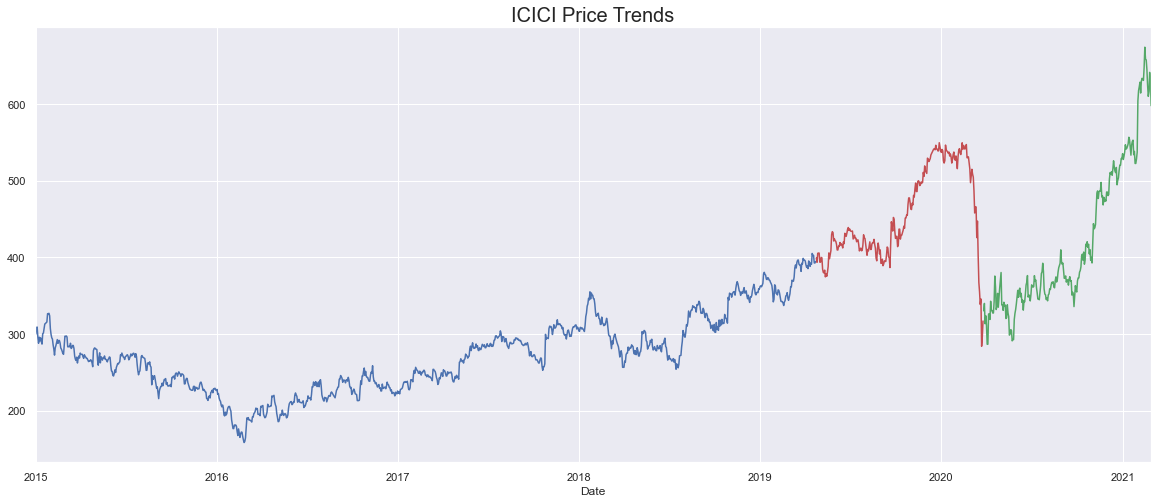

In [78]:
df_train.icici.plot(figsize = (20,8), color="b")
df_val.icici.plot(color="r")
df_test.icici.plot(color="g")
plt.title("ICICI Price Trends", size=20)
plt.show()

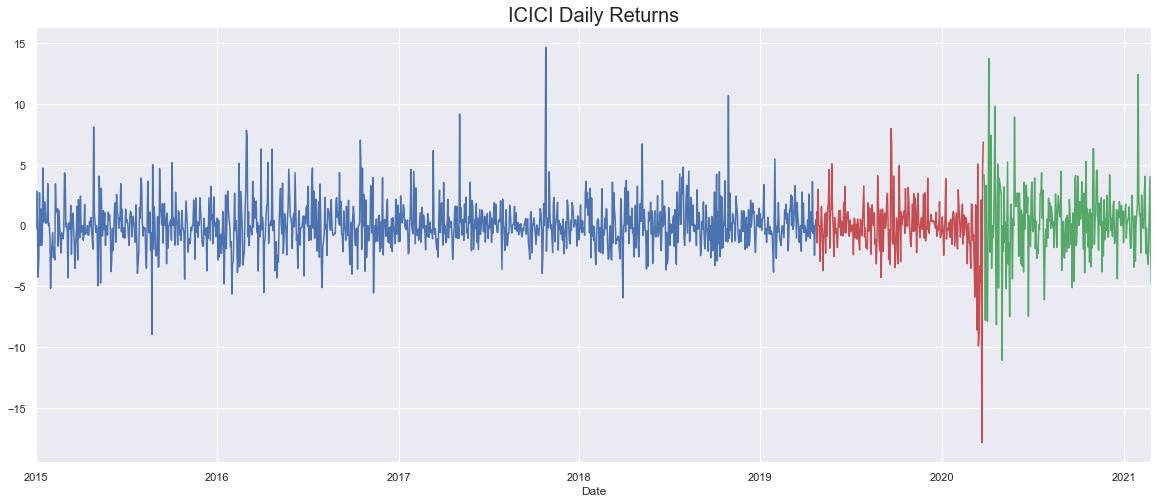

In [80]:
df_train.icici_ret.plot(figsize = (20,8), color="b")
df_val.icici_ret.plot(color="r")
df_test.icici_ret.plot(color="g")
plt.title("ICICI Daily Returns", size=20)
plt.show()

### Testing for Stationarity : Augmented Dickey Fuller Test

In [9]:
sts.adfuller(df.icici)

(-0.5700050875464222,
 0.8776166383573119,
 9,
 1598,
 {'1%': -3.4344487706424953,
  '5%': -2.8633503662338877,
  '10%': -2.567733803393165},
 10859.726996621335)

The ADF statistics is greater than the critical value; Failed to show stationarity with respect to price.

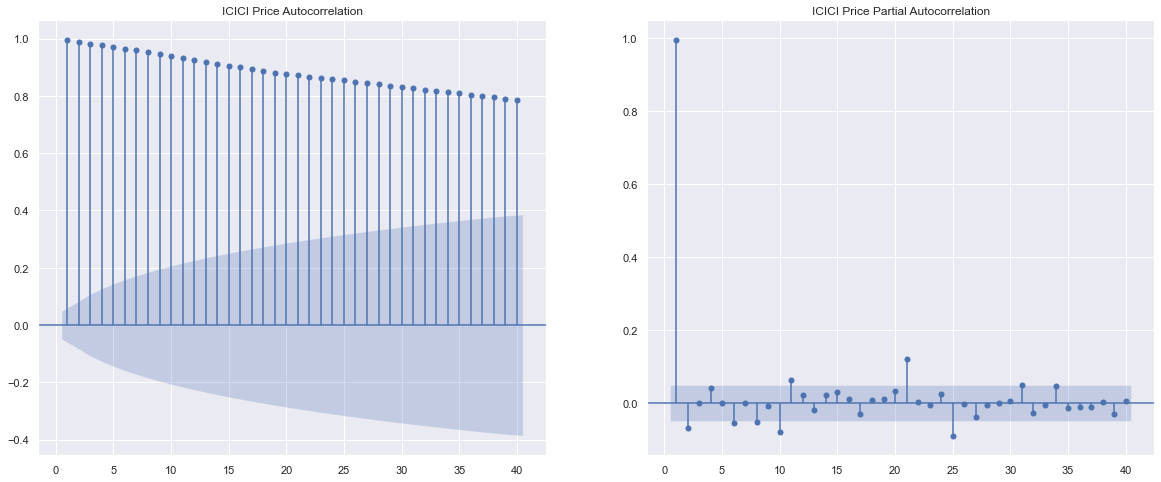

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sgt.plot_acf(df.icici, lags=40, zero=False, ax=ax1, title='ICICI Price Autocorrelation')
sgt.plot_pacf(df.icici,lags=40, zero=False, ax=ax2, title='ICICI Price Partial Autocorrelation')
plt.show()

In [11]:
sts.adfuller(df.icici_ret[1:])

(-12.64955412400665,
 1.377883163305409e-23,
 9,
 1597,
 {'1%': -3.434451341329522,
  '5%': -2.863351500889469,
  '10%': -2.567734407591096},
 7004.142302135972)

The ADF statistics is far below the critical value; Stationarity Found. We can use this data for further analysis

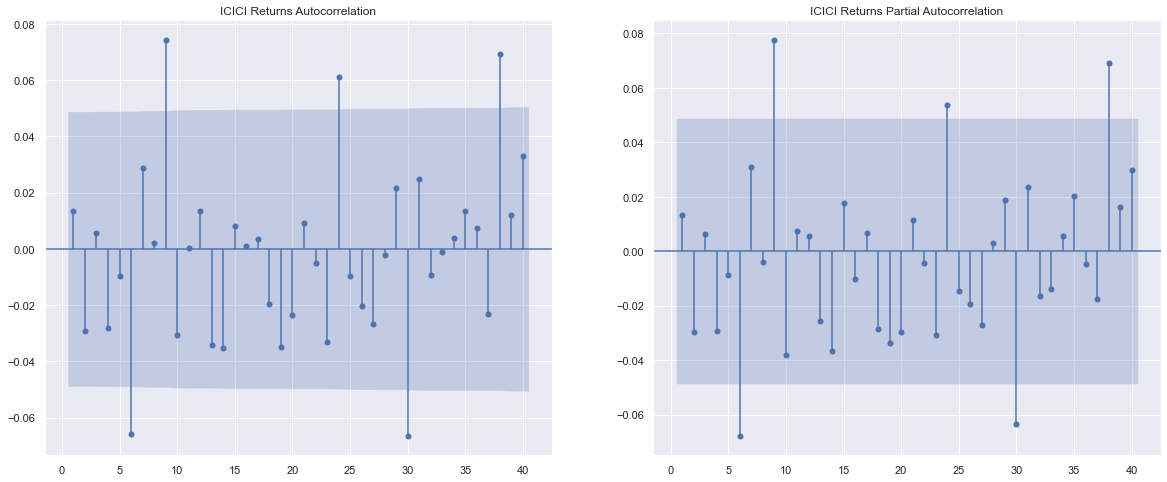

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sgt.plot_acf(df.icici_ret[1:], lags=40, zero=False, ax=ax1,title='ICICI Returns Autocorrelation')
sgt.plot_pacf(df.icici_ret[1:],lags=40, zero=False, ax=ax2,title='ICICI Returns Partial Autocorrelation' )
plt.show()

6th and 9th lag is significant in our analysis; we can start our analysis by taking p=6 and q=6.

### Testing for seasonality

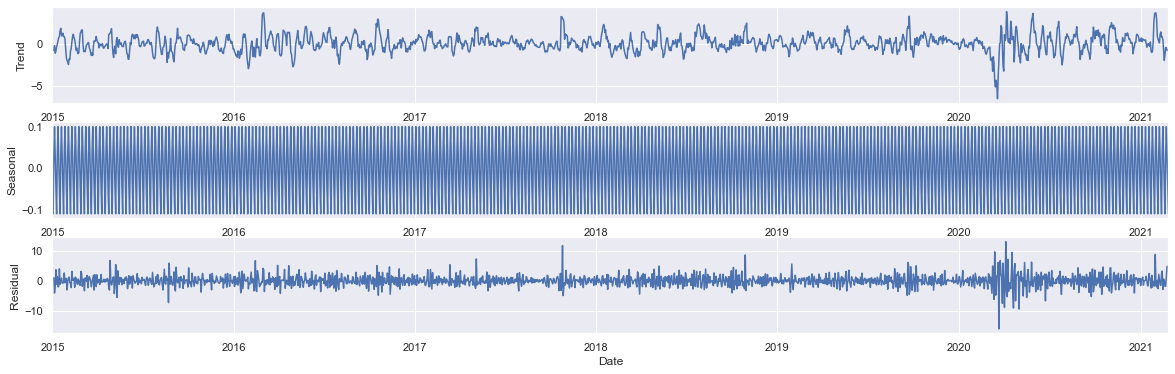

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6))
season=seasonal_decompose(df.icici_ret[1:], model='additive') 
season.trend.plot(ax=ax1)
ax1.set_ylabel("Trend")
season.seasonal.plot(ax=ax2)
ax2.set_ylabel("Seasonal")
season.resid.plot(ax=ax3)
ax3.set_ylabel("Residual")
plt.show()

Seasonal fluctuations are close to 0. Hence, we can say that Actual=Trend+Residual+Seasonal(seasonal is close to zero) 

### Log Likelihood Ratio Test

In [14]:
def LLR_test(mod_1, mod_2, df):
    from scipy.stats import chi2
    l1=mod_1.llf
    l2=mod_2.llf
    p=chi2.sf(2*(l2-l1), df).round(3)
    return p

### Searching for a good model

In [16]:
best_model=[]
for p in range(0, 7):
    for q in range(0, 7):
        order=(p,0,q)
        model=ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=order)
        results=model.fit()
        if (p==0 & q==0):
            best=(p, q, results.aic)
        best_model.append((p, q, results.aic))
        if (results.aic < best[2]):
            best=(p, q, results.aic)
            print(best)
        else:
            continue

(1, 0, 4025.1323783853213)
(1, 3, 4022.8245590280894)
(5, 3, 4022.0959275160712)
(5, 5, 4021.7885703880575)
(6, 3, 4020.8977802221534)


In [19]:
p_list=[]
q_list=[]
aic_list=[]
for p,q,aic in best_model:
    p_list.append(p)
    q_list.append(q)
    aic_list.append(aic)
aic=pd.Series(aic_list)
md=pd.DataFrame(aic)
md["p"]=pd.Series(p_list)
md["q"]=pd.Series(q_list)
md = md.sort_values(0)
md.head()

,0,p,q
45,4020.897780,6,3
40,4021.788570,5,5
38,4022.095928,5,3
10,4022.824559,1,3
22,4022.852199,3,1


The best model 5 according to the lowest AIC value is ARMA(6, 3), ARMA(5,5) ARMA(1,3) and ARMA(3,1)

### Summary Statistics for ARMA(6,3)

In [20]:
arma63 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(6,0,3))
result_arma63=arma63.fit()

In [21]:
result_arma63.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1124
Model:                     ARMA(6, 3)   Log Likelihood               -1996.449
Method:                       css-mle   S.D. of innovations              1.425
Date:                Sat, 27 Feb 2021   AIC                           4020.898
Time:                        17:40:23   BIC                           4091.243
Sample:                    01-01-2015   HQIC                          4047.482
                         - 04-23-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0201      0.008      2.577      0.010       0.005       0.035
bse_ret             2.7799      0.406      6.854      0.000       1.985       3.575
nse_ret            -0.8874      0.402     -2.205      0.027      -1.676      -0.099
hdfc_ret           -0.4396      0.057     -7.671      0.000      -0.552      -0.327
ar.L1.icici_ret    -0.4544      0.030    -15.137      0.000      -0.513      -0.396
ar.L2.icici_ret     0.4759      0.033     14.459      0.000       0.411       0.540
ar.L3.icici_ret     0.9562      0.036     26.713      0.000       0.886       1.026
ar.L4.icici_ret    -0.0374      0.036     -1.041      0.298      -0.108       0.033
ar.L5.icici_ret    -0.0346      0.033     -1.049      0.294      -0.099       0.030
ar.L6.icici_ret     0.0359      0.030      1.192      0.233      -0.023       0.095
ma.L1.icici_ret     0.4552      0.005    100.337      0.000       0.446       0.464
ma.L2.icici_ret    -0.4551      0.005    -97.763      0.000      -0.464      -0.446
ma.L3.icici_ret    -0.9999      0.005   -205.581      0.000      -1.009      -0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7279           -0.6959j            1.0070           -0.3786
AR.2           -0.7279           +0.6959j            1.0070            0.3786
AR.3            1.0176           -0.0000j            1.0176           -0.0000
AR.4           -2.5942           -0.0000j            2.5942           -0.5000
AR.5            1.9982           -2.5328j            3.2261           -0.1437
AR.6            1.9982           +2.5328j            3.2261            0.1437
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7276           -0.6860j            1.0000           -0.3797
MA.3           -0.7276           +0.6860j            1.0000            0.3797
-----------------------------------------------------------------------------
"""

### Summary Statistics for ARMA(5,5)

In [22]:
arma55 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(5,0,5))
result_arma55=arma55.fit()

In [23]:
result_arma55.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1124
Model:                     ARMA(5, 5)   Log Likelihood               -1995.894
Method:                       css-mle   S.D. of innovations              1.426
Date:                Sat, 27 Feb 2021   AIC                           4021.789
Time:                        17:41:30   BIC                           4097.158
Sample:                    01-01-2015   HQIC                          4050.271
                         - 04-23-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0210      0.008      2.699      0.007       0.006       0.036
bse_ret             2.5741      0.412      6.247      0.000       1.767       3.382
nse_ret            -0.6734      0.407     -1.654      0.098      -1.471       0.125
hdfc_ret           -0.4531      0.058     -7.853      0.000      -0.566      -0.340
ar.L1.icici_ret     0.1738      0.027      6.538      0.000       0.122       0.226
ar.L2.icici_ret     0.0416      0.029      1.415      0.157      -0.016       0.099
ar.L3.icici_ret    -0.0907      0.027     -3.370      0.001      -0.143      -0.038
ar.L4.icici_ret    -0.1317      0.027     -4.942      0.000      -0.184      -0.079
ar.L5.icici_ret     0.9325      0.026     36.399      0.000       0.882       0.983
ma.L1.icici_ret    -0.1834      0.021     -8.859      0.000      -0.224      -0.143
ma.L2.icici_ret    -0.0348      0.024     -1.469      0.142      -0.081       0.012
ma.L3.icici_ret     0.0503      0.023      2.223      0.026       0.006       0.095
ma.L4.icici_ret     0.1397      0.021      6.802      0.000       0.099       0.180
ma.L5.icici_ret    -0.9718      0.021    -47.351      0.000      -1.012      -0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0174           -0.0000j            1.0174           -0.0000
AR.2            0.3833           -0.9276j            1.0037           -0.1876
AR.3            0.3833           +0.9276j            1.0037            0.1876
AR.4           -0.8214           -0.6096j            1.0229           -0.3984
AR.5           -0.8214           +0.6096j            1.0229            0.3984
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.3792           -0.9267j            1.0013           -0.1882
MA.3            0.3792           +0.9267j            1.0013            0.1882
MA.4           -0.8073           -0.6121j            1.0131           -0.3967
MA.5           -0.8073           +0.6121j            1.0131            0.3967
-----------------------------------------------------------------------------
"""

#### Checking in terms of Log-Likelihood Ratio: LLR_test

In [25]:
LLR_test(result_arma63, result_arma55,1)

0.292

ARMA(6,3) is better with respect to Log-Likelihood Function

### Summary Statistics for ARMA(5,3)

In [26]:
arma53 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(5,0,3))
result_arma53=arma53.fit()

In [27]:
result_arma53.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1124
Model:                     ARMA(5, 3)   Log Likelihood               -1998.048
Method:                       css-mle   S.D. of innovations              1.430
Date:                Sat, 27 Feb 2021   AIC                           4022.096
Time:                        17:44:53   BIC                           4087.416
Sample:                    01-01-2015   HQIC                          4046.781
                         - 04-23-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0209      0.008      2.717      0.007       0.006       0.036
bse_ret             2.6320      0.413      6.372      0.000       1.822       3.442
nse_ret            -0.7288      0.408     -1.786      0.074      -1.529       0.071
hdfc_ret           -0.4531      0.058     -7.815      0.000      -0.567      -0.339
ar.L1.icici_ret    -0.5771      0.036    -16.199      0.000      -0.647      -0.507
ar.L2.icici_ret     0.6151      0.036     16.908      0.000       0.544       0.686
ar.L3.icici_ret     0.9492      0.037     25.979      0.000       0.878       1.021
ar.L4.icici_ret    -0.0247      0.035     -0.705      0.481      -0.093       0.044
ar.L5.icici_ret    -0.0240      0.031     -0.781      0.435      -0.084       0.036
ma.L1.icici_ret     0.5741      0.020     29.134      0.000       0.535       0.613
ma.L2.icici_ret    -0.5976      0.012    -49.025      0.000      -0.622      -0.574
ma.L3.icici_ret    -0.9764      0.019    -52.614      0.000      -1.013      -0.940
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8195           -0.6105j            1.0219           -0.3981
AR.2           -0.8195           +0.6105j            1.0219            0.3981
AR.3            1.0184           -0.0000j            1.0184           -0.0000
AR.4            6.0568           -0.0000j            6.0568           -0.0000
AR.5           -6.4652           -0.0000j            6.4652           -0.5000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8060           -0.6119j            1.0120           -0.3967
MA.3           -0.8060           +0.6119j            1.0120            0.3967
-----------------------------------------------------------------------------
"""

In [28]:
LLR_test(result_arma53, result_arma63, 1)

0.074

ARMA(5,3) is not significantly different from ARMA(6,3) so simpler model is better. Hence, ARMA(5,3) is preffered.

### Summary Statistics for ARMA(1,3)

In [29]:
arma13 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(1,0,3))
result_arma13=arma13.fit()

In [30]:
result_arma13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1124
Model:                     ARMA(1, 3)   Log Likelihood               -2002.412
Method:                       css-mle   S.D. of innovations              1.437
Date:                Sat, 27 Feb 2021   AIC                           4022.825
Time:                        17:48:22   BIC                           4068.046
Sample:                    01-01-2015   HQIC                          4039.914
                         - 04-23-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0173      0.029      0.591      0.555      -0.040       0.075
bse_ret             2.6306      0.421      6.242      0.000       1.805       3.457
nse_ret            -0.7498      0.416     -1.805      0.071      -1.564       0.065
hdfc_ret           -0.4385      0.058     -7.579      0.000      -0.552      -0.325
ar.L1.icici_ret     0.8934      0.074     12.151      0.000       0.749       1.037
ma.L1.icici_ret    -0.8991      0.079    -11.427      0.000      -1.053      -0.745
ma.L2.icici_ret     0.0307      0.040      0.762      0.446      -0.048       0.109
ma.L3.icici_ret    -0.0597      0.032     -1.874      0.061      -0.122       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1193           +0.0000j            1.1193            0.0000
MA.1            1.0699           -0.0000j            1.0699           -0.0000
MA.2           -0.2782           -3.9469j            3.9567           -0.2612
MA.3           -0.2782           +3.9469j            3.9567            0.2612
-----------------------------------------------------------------------------
"""

In [31]:
LLR_test(result_arma13, result_arma53, 4)

0.068

ARMA(1,3) is not significantly different from ARMA(5,3) so simpler model is better. Hence, ARMA(1,3) is preffered.

### Summary Statistics for ARMA(3,1)

In [32]:
arma31 = ARIMA(df_train.icici_ret[1:],exog=df_train[["bse_ret", "nse_ret", "hdfc_ret"]][1:], order=(3,0,1))
result_arma31=arma31.fit()

In [33]:
result_arma31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              icici_ret   No. Observations:                 1124
Model:                     ARMA(3, 1)   Log Likelihood               -2002.426
Method:                       css-mle   S.D. of innovations              1.437
Date:                Sat, 27 Feb 2021   AIC                           4022.852
Time:                        17:50:11   BIC                           4068.074
Sample:                    01-01-2015   HQIC                          4039.942
                         - 04-23-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0172      0.030      0.582      0.560      -0.041       0.075
bse_ret             2.6293      0.422      6.237      0.000       1.803       3.455
nse_ret            -0.7481      0.416     -1.800      0.072      -1.563       0.066
hdfc_ret           -0.4386      0.058     -7.579      0.000      -0.552      -0.325
ar.L1.icici_ret     0.9234      0.069     13.403      0.000       0.788       1.058
ar.L2.icici_ret     0.0312      0.041      0.764      0.445      -0.049       0.111
ar.L3.icici_ret    -0.0582      0.032     -1.835      0.067      -0.120       0.004
ma.L1.icici_ret    -0.9295      0.063    -14.778      0.000      -1.053      -0.806
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1308           +0.0000j            1.1308            0.0000
AR.2            3.6138           +0.0000j            3.6138            0.0000
AR.3           -4.2077           +0.0000j            4.2077            0.5000
MA.1            1.0758           +0.0000j            1.0758            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
LLR_test(result_arma31, result_arma53, 4)

0.067

Since, both ARMA(1,3) and ARMA(3,1) have same degrees of freedom and both are better then our last best model hence 
we can say that both are similar model with respect to Log-Likelihood Function and we can choose either of them. 
But as per the AIC we can say that ARMA(1,3) is preffered over ARMA(3,1).

### Predicted Returns for Test Set using ARMA(1,3)

In [46]:
start_date="2019-04-24"
end_date="2020-03-25" 

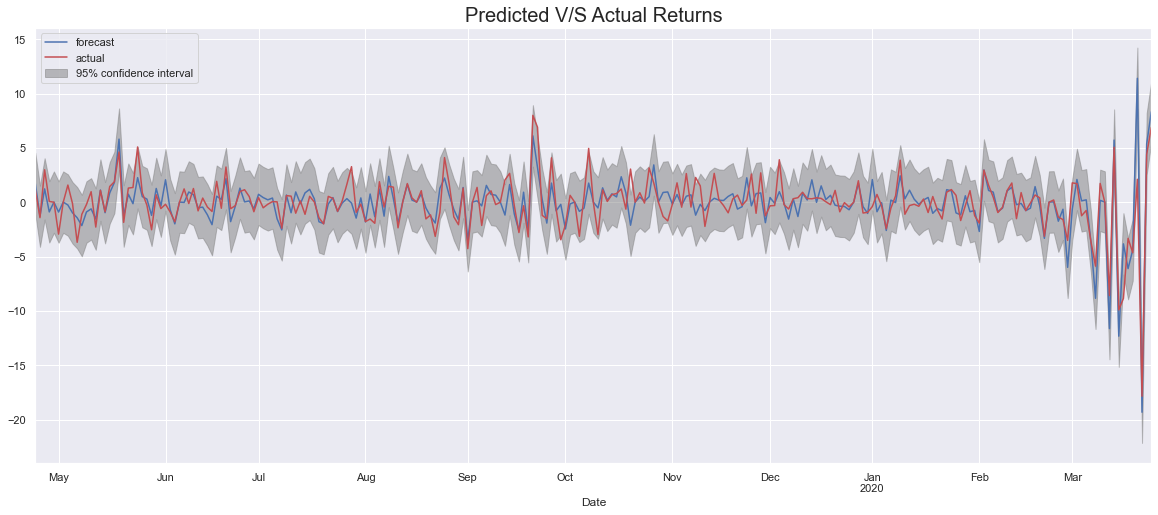

In [109]:
fig, ax= plt.subplots(1,1,figsize=(20,8))
result_arma13.plot_predict(start=start_date, end = end_date, ax=ax, alpha=0.05, dynamic=True, plot_insample=False,
                               exog=df_val[["bse_ret", "nse_ret", "hdfc_ret"]][start_date:end_date])
df_val.icici_ret.plot(color='r', ax=ax, label='actual')
plt.title("Predicted V/S Actual Returns", size=20)
plt.legend()
plt.show()

### Checking Residuals for Overfitting Case

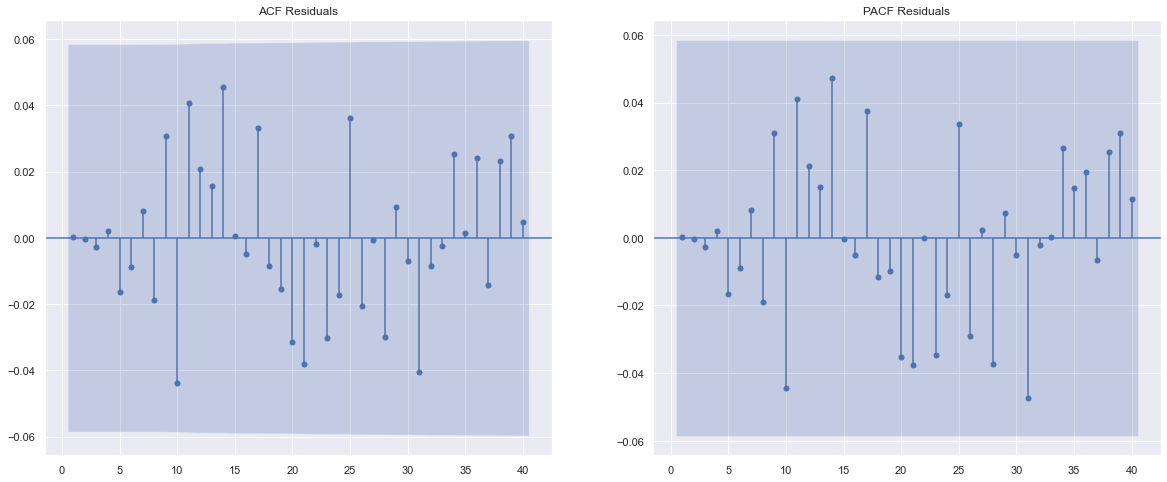

In [106]:
res_13 = result_arma13.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sgt.plot_acf(res_13, lags=40, zero=False, ax=ax1, title="ACF Residuals")
sgt.plot_pacf(res_13, lags= 40, zero=False, ax=ax2, title="PACF Residuals")
plt.show()

No Overfitting Found, the 5th and 10th and 14th lags are close to being significant but they are not significant, hence no overfitting.

In [50]:
len(df_test.icici_ret)

242

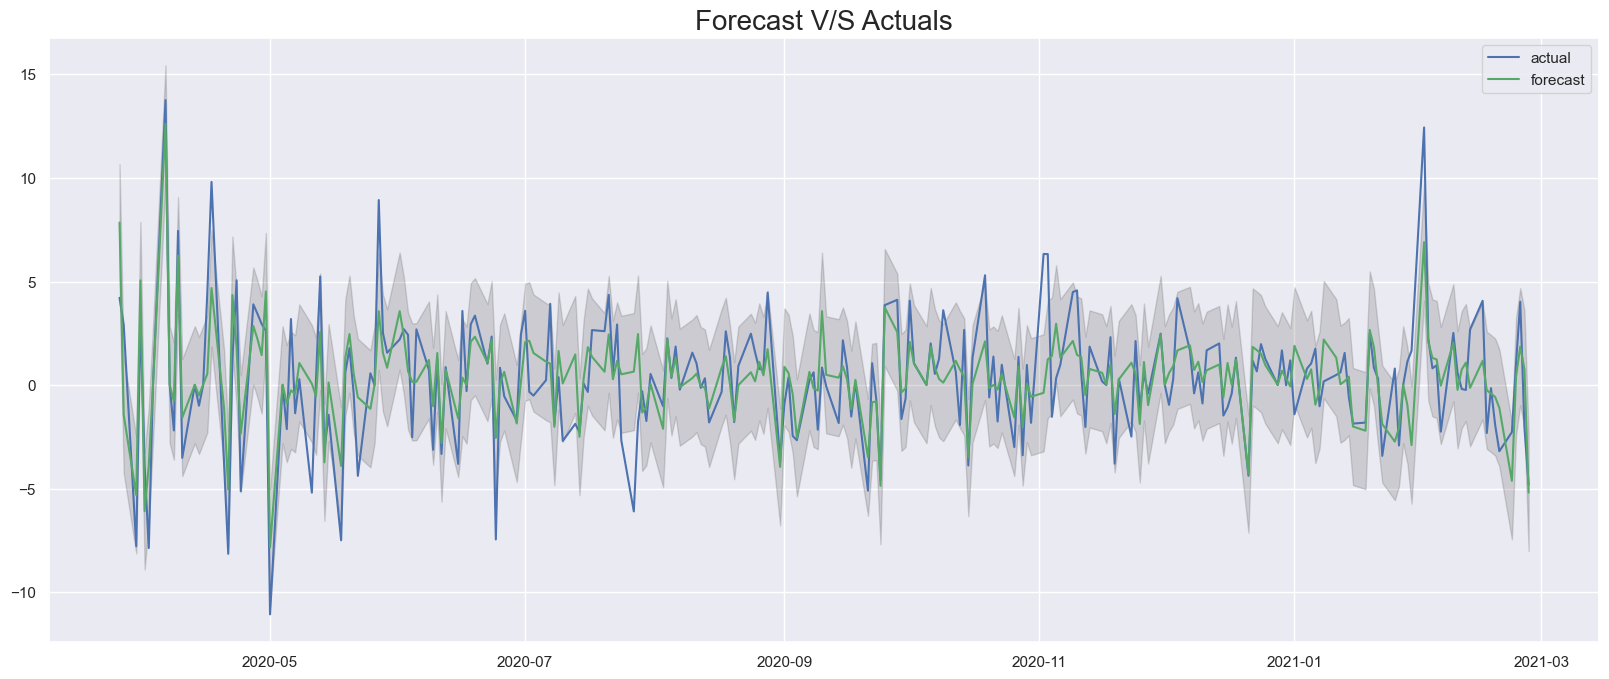

In [107]:
fc, se, conf= result_arma13.forecast(242, alpha=0.05, exog=df_test[["bse_ret", "nse_ret", "hdfc_ret"]][end_date:])
# Make as pandas series
fc_series = pd.Series(fc, index=df_test.icici_ret.index)
lower_series = pd.Series(conf[:, 0], index=df_test.icici_ret.index)
upper_series = pd.Series(conf[:, 1], index=df_test.icici_ret.index)

# Plot
plt.figure(figsize=(20, 8), dpi=100)
#plt.plot(df_train.icici_ret, label='training')
plt.plot(df_test.icici_ret, label='actual', color='b')
plt.plot(fc_series, label='forecast', color='g')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast V/S Actuals', size=20)
plt.legend()
plt.show()

### Forecasting Volatality

In [52]:
model1 = arch_model(
            df.icici_ret[1:],
            mean="constant",
            vol="GARCH",
            p=1,
            q=1
            )
results1 = model1.fit(last_obs= start_date, update_freq=10)
results1.summary()

Iteration:     10,   Func. Count:     63,   Neg. LLF: 2330.350192946568
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2330.350192946568
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              icici_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2330.35
Distribution:                  Normal   AIC:                           4668.70
Method:            Maximum Likelihood   BIC:                           4688.80
                                        No. Observations:                 1124
Date:                Sat, Feb 27 2021   Df Residuals:                     1123
Time:                        18:03:42   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0575  5.709e-02      1.006      0.314 [-5.445e-02,  0.169]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3798      0.220      1.725  8.448e-02   [-5.167e-02,  0.811]
alpha[1]       0.0315  1.956e-02      1.611      0.107 [-6.815e-03,6.985e-02]
beta[1]        0.8668  5.714e-02     15.171  5.502e-52      [  0.755,  0.979]
=============================================================================

Covariance estimator: robust
"""

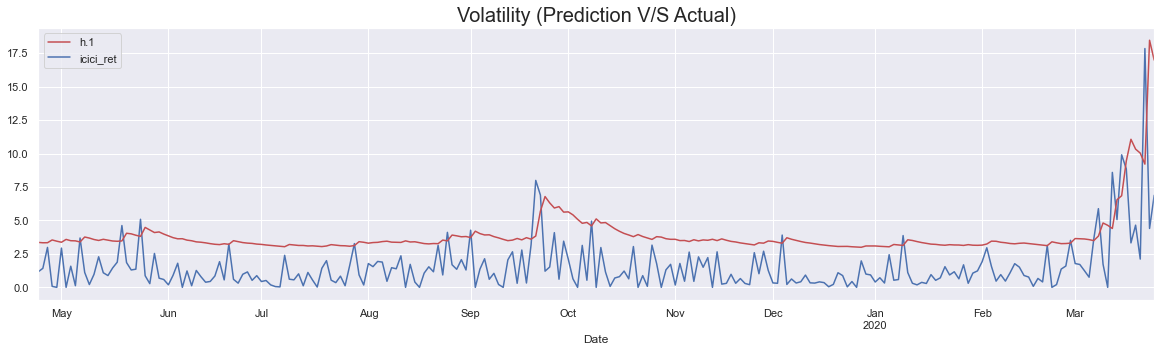

In [116]:
pred_garch = results1.forecast(horizon=1, align="target")
pred_garch.residual_variance[start_date:end_date].plot(figsize=(20,5), zorder=2, color='r')
df_val.icici_ret.abs().plot(zorder=1)
plt.title("Volatility (Prediction V/S Actual)", size=20)
plt.legend()
plt.show()

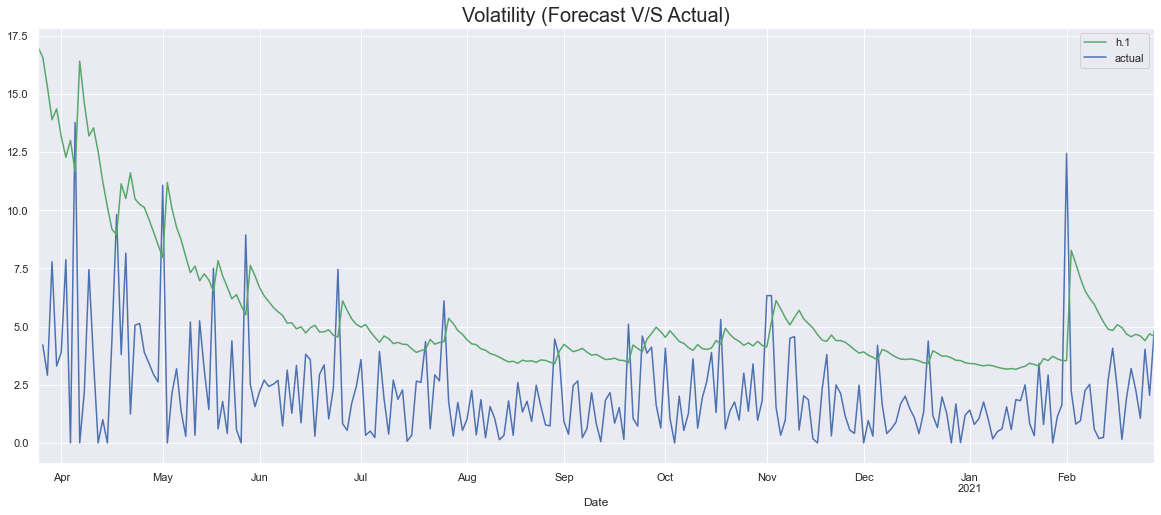

In [113]:
pred_vol=results1.forecast(horizon=1, align="target")
pred_vol.residual_variance[end_date:].plot(figsize=(20,8), zorder=2, color='g', label="forecast")
df_test.icici_ret.abs().plot(zorder=1, label='actual')
plt.title("Volatility (Forecast V/S Actual)", size=20)
plt.legend()
plt.show()